In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import time
import cv2

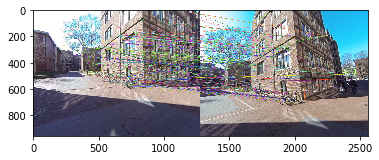

In [2]:
#image  cis.upenn.edu/~cis580/Spring2015/Projects/proj2/SfMProjectData.zip

img1 = cv2.imread('image0000001.bmp')
img2 = cv2.imread('image0000002.bmp')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
#Oriented FAST and Rotated BRIEF
orb = cv2.ORB_create(edgeThreshold=3)

# find the keypoints with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)

plt.imshow(img3)
plt.show()

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import cv2
import glob, os
from mpl_toolkits import mplot3d

from Normalized8pointsAlgo import RANSAC
from CameraConfig import *
from Triangulation import *

In [4]:
trainPoints = cv2.KeyPoint_convert([kp1[m.queryIdx] for m in matches])
queryPoints = cv2.KeyPoint_convert([kp2[m.trainIdx] for m in matches])
pts1 = np.int32(trainPoints)
pts2 = np.int32(queryPoints)

In [5]:
#Fundamental matrix https://docs.opencv.org/trunk/da/de9/tutorial_py_epipolar_geometry.html
my_F, train_inliers, query_inliers, ind = RANSAC(pts1, pts2, max_iter_times = 1000) 

F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

WARNING(normalise2dpts): Some points are at infinity
WARNING(normalise2dpts): Some points are at infinity
[RANSAC] takes  0.09997320175170898 sec
[RANSAC] iteration 14  err: 0.005019169449635179


In [6]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    (r,c,_) = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [7]:
print(my_F)
print(F)

[[-9.12862700e-12 -8.75307331e-12  1.79962779e-06]
 [-3.80216954e-11 -4.34282411e-11  8.67634520e-06]
 [ 4.97603391e-06  4.94184887e-06 -1.00986523e+00]]
[[ 2.36442838e-07 -6.45414861e-06  3.07951377e-03]
 [ 7.46451452e-06 -4.43904138e-07 -2.49542460e-03]
 [-4.66200294e-03  1.41604989e-03  1.00000000e+00]]


my Fundamental matrix


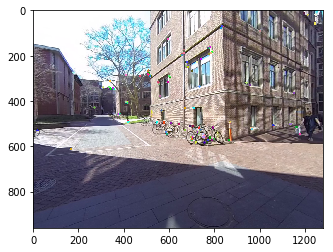

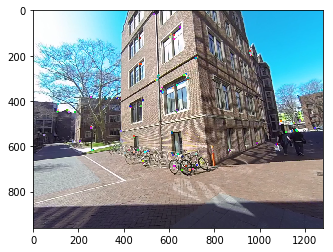

In [8]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(query_inliers.reshape(-1,1,2), 2, my_F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1.copy(),img2.copy(),lines1,train_inliers,query_inliers)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(train_inliers.reshape(-1,1,2), 1, my_F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2.copy(),img1.copy(),lines2,query_inliers,train_inliers)
print("my Fundamental matrix")
plt.imshow(img5)
plt.show()
plt.imshow(img3)
plt.show()
#print(lines1[:20])
#print(lines2[:20])

opencv Fundamental matrix


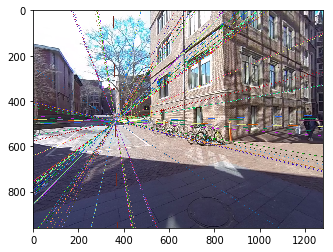

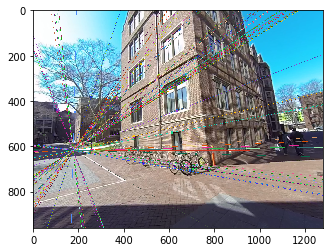

In [9]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1.copy(),img2.copy(),lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1, F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2.copy(),img1.copy(),lines2,pts2,pts1)
print("opencv Fundamental matrix")
plt.imshow(img5)
plt.show()
plt.imshow(img3)
plt.show()
#print(lines1[:20])
#print(lines2[:20])

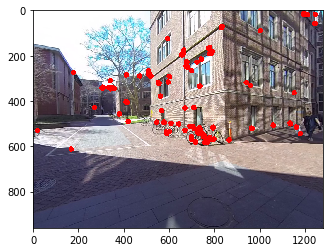

my inliers


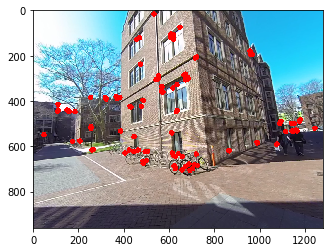

In [10]:
imageA = img1.copy()
imageB = img2.copy()
for i in train_inliers:
    imageA = cv2.circle(imageA , (int(i[0]), int(i[1])), 2, (255, 0, 0), 20)
plt.imshow(imageA)
plt.show()
for i in query_inliers:
    imageB = cv2.circle(imageB , (int(i[0]), int(i[1])), 2, (255, 0, 0), 20)
print("my inliers")
plt.imshow(imageB)
plt.show()


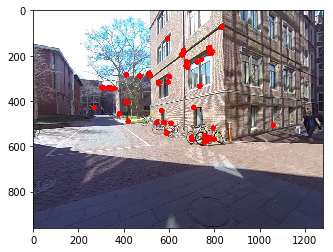

opencv inliers


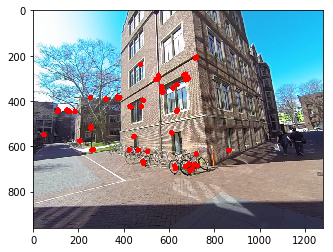

In [11]:
imageA = img1.copy()
imageB = img2.copy()
for i in pts1:
    imageA = cv2.circle(imageA , (int(i[0]), int(i[1])), 2, (255, 0, 0), 20)
plt.imshow(imageA)
plt.show()
for i in pts2:
    imageB = cv2.circle(imageB , (int(i[0]), int(i[1])), 2, (255, 0, 0), 20)
print("opencv inliers")
plt.imshow(imageB)
plt.show()

In [14]:
f1 = 568.996140852
f2 = 568.988362396
s = 0
mx = my = 1
px = 643.21055941
py = 477.982801038
K = np.array([[f1*mx, s, px],[0, f2*my, py], [0, 0, 1]])
W = np.array([[0, -1, 0],[1, 0 ,0], [0, 0, 1]])
eps = 1e-12

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

my F results
len(points): 170


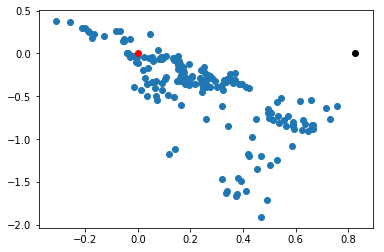

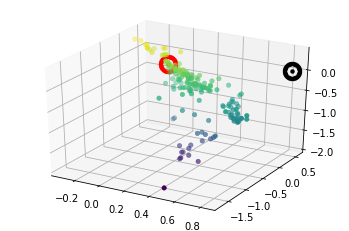

In [16]:
print('my F results')

E = getEssentialMatrix(my_F)
U, D, Vh = getEssentialConfig(E)

#first camera
C0 = np.array([0,0,0])
R0 = np.array([[1,0,0],[0,1,0],[0,0,1]])

#second camera
C1, R1 = CameraPosition1Config(U, D, Vh)
C2, R2 = CameraPosition2Config(U, D, Vh)
C3, R3 = CameraPosition3Config(U, D, Vh)
C4, R4 = CameraPosition4Config(U, D, Vh)
Cs = [C1,C2,C3,C4]
Rs = [R1,R2,R3,R4]

best_ct = 0
best_secondCamera_C = None
best_secondCamera_R = None
points = None

for C,R in zip(Cs, Rs):
    P1, P2 = getCameraMatrix(K, R0, C0, R, C)    
    temp_points = getWorldPoints(train_inliers, query_inliers, P1, P2)
    n_in_front_of_C1, n_in_front_of_C2 = CheckCheirality(temp_points, C1, R1, C2, R2)
    if(n_in_front_of_C1 + n_in_front_of_C2 > best_ct):
        best_ct = n_in_front_of_C1 + n_in_front_of_C2
        best_secondCamera_C = C
        best_secondCamera_R = R
        points = temp_points
#print("max points in front of both cameras:", best_ct)
print("len(points):",len(points))
#XZ
plt.scatter(points[:,0], points[:,2])
plt.scatter(C0[0], C0[2], c='red')
plt.scatter(C1[0], C1[2], c='black')
plt.show()
ax = plt.axes(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], c=points[:,2], cmap='viridis', linewidth=0.5);
ax.scatter(C0[0], C0[1], C0[2], c='red', linewidth=15);
ax.scatter(C1[0], C1[1], C1[2], c='black', linewidth=15);
plt.show()

opencv F results
len(points): 170


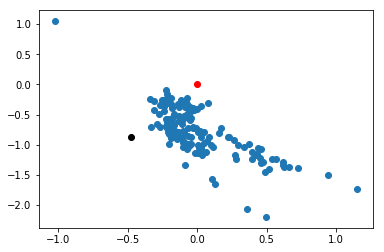

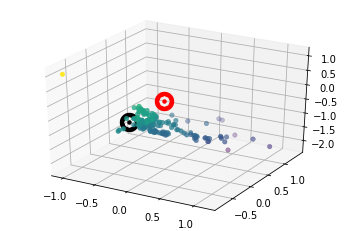

In [17]:
print('opencv F results')

E = getEssentialMatrix(F)
U, D, Vh = getEssentialConfig(E)

#first camera
C0 = np.array([0,0,0])
R0 = np.array([[1,0,0],[0,1,0],[0,0,1]])

#second camera
C1, R1 = CameraPosition1Config(U, D, Vh)
C2, R2 = CameraPosition2Config(U, D, Vh)
C3, R3 = CameraPosition3Config(U, D, Vh)
C4, R4 = CameraPosition4Config(U, D, Vh)
Cs = [C1,C2,C3,C4]
Rs = [R1,R2,R3,R4]

best_ct = 0
best_secondCamera_C = None
best_secondCamera_R = None
points = None

for C,R in zip(Cs, Rs):
    P1, P2 = getCameraMatrix(K, R0, C0, R, C)    
    temp_points = getWorldPoints(train_inliers, query_inliers, P1, P2)
    n_in_front_of_C1, n_in_front_of_C2 = CheckCheirality(temp_points, C1, R1, C2, R2)
    if(n_in_front_of_C1 + n_in_front_of_C2 > best_ct):
        best_ct = n_in_front_of_C1 + n_in_front_of_C2
        best_secondCamera_C = C
        best_secondCamera_R = R
        points = temp_points
#print("max points in front of both cameras:", best_ct)
print("len(points):",len(points))
#XZ
plt.scatter(points[:,0], points[:,2])
plt.scatter(C0[0], C0[2], c='red')
plt.scatter(C1[0], C1[2], c='black')
plt.show()
ax = plt.axes(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], c=points[:,2], cmap='viridis', linewidth=0.5);
ax.scatter(C0[0], C0[1], C0[2], c='red', linewidth=15);
ax.scatter(C1[0], C1[1], C1[2], c='black', linewidth=15);
plt.show()